In [1]:
#packages
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt         
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from tensorflow.keras import models, layers

In [2]:
#
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# IMAGE_SIZE = (150, 150)



In [15]:
#try same model with resizing
dim = (75,75)

In [16]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../../../../archive/seg_train/seg_train', '../../../../archive/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, dim) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [17]:
(train_images_resized, train_labels), (test_images_resized, test_labels) = load_data()

  8%|▊         | 185/2191 [00:00<00:01, 1838.80it/s]

Loading ../../../../archive/seg_train/seg_train


 45%|████▍     | 195/437 [00:00<00:00, 1948.26it/s]

Loading ../../../../archive/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1785.86it/s]


In [18]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

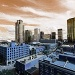

In [19]:
#before reshaping
imshow(train_images_resized[1])

In [21]:
train_images_resized_scaled =train_images_resized.astype('float32') / 255.0
test_images_resized_scaled = test_images_resized.astype('float32') / 255.0

In [22]:
dropout_model_resized_2 = models.Sequential()

In [23]:
dropout_model_resized_2.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))
dropout_model_resized_2.add(layers.MaxPooling2D(3,3))
dropout_model_resized_2.add(layers.Dropout(0.35))
dropout_model_resized_2.add(layers.Flatten())
dropout_model_resized_2.add(layers.Dense(128,activation='relu'))
dropout_model_resized_2.add(layers.Dense(6,activation='softmax'))

In [24]:
dropout_model_resized_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9437312   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 9,441,670
Trainable params: 9,441,670
Non-trainable params: 0
______________________________________________

In [25]:
dropout_model_resized_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [26]:
#added checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("../../../../Models/resized_dropout_model_2.h5", save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
)

In [27]:
history = dropout_model_resized_2.fit(train_images_resized_scaled,train_labels,
                    batch_size=16,
                    epochs=5,
                    validation_data=(test_images_resized_scaled,test_labels),
                    callbacks=[checkpoint,earlystop])

Epoch 1/5
878/878 [==============================] - 69s 78ms/step - loss: 1.0072 - acc: 0.6308 - val_loss: 0.8711 - val_acc: 0.6827
Epoch 2/5
878/878 [==============================] - 67s 76ms/step - loss: 0.7217 - acc: 0.7345 - val_loss: 0.7713 - val_acc: 0.7167
Epoch 3/5
878/878 [==============================] - 66s 76ms/step - loss: 0.5659 - acc: 0.7941 - val_loss: 1.0899 - val_acc: 0.6437
Epoch 4/5
878/878 [==============================] - 66s 75ms/step - loss: 0.4505 - acc: 0.8392 - val_loss: 0.7375 - val_acc: 0.7517
Epoch 5/5
878/878 [==============================] - 66s 75ms/step - loss: 0.3370 - acc: 0.8814 - val_loss: 0.8163 - val_acc: 0.7360


Text(20.625, 0.5, 'Accuracy')

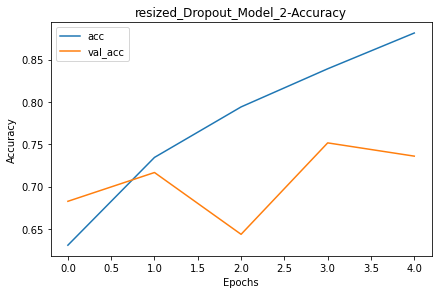

In [28]:
metrics = ['acc','val_acc']
for metric in metrics:
    plt.plot(history.history[metric], label=metric)
plt.title('resized_Dropout_Model_2-Accuracy')
plt.legend()
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(27.0, 0.5, 'Loss')

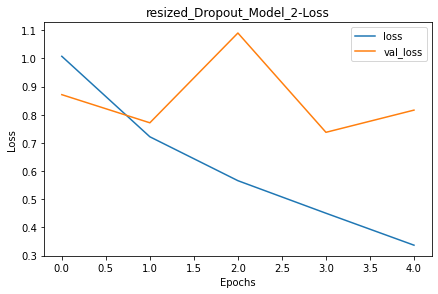

In [29]:
metrics = ['loss','val_loss']
for metric in metrics:
    plt.plot(history.history[metric], label=metric)
plt.title('resized_Dropout_Model_2-Loss')

plt.legend()
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [30]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [31]:

def modeler(layers_list):
    model = models.Sequential()
    model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))

    for layer in layers_list:
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    
    
 
    return model

In [32]:
def model_trainer(model,name,train_img,train_labels,test_img,test_labels,batch_size=16,epochs=5):
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../../../../Models/{name}_model.h5', save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
    )
    history = model.fit(train_img,train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_img,test_labels),
                    callbacks=[checkpoint,earlystop])
    
    return history

In [33]:
layers_list = [layers.MaxPooling2D(3,3),
               layers.Dropout(0.35)]

model = modeler(layers_list)

In [34]:
history = model_trainer(model,'trimming',train_images_resized_scaled,train_labels,test_images_resized_scaled,test_labels,epochs=5)

Epoch 1/5
878/878 [==============================] - 67s 77ms/step - loss: 1.0018 - acc: 0.6305 - val_loss: 0.8190 - val_acc: 0.6950
Epoch 2/5
878/878 [==============================] - 67s 76ms/step - loss: 0.7124 - acc: 0.7398 - val_loss: 0.7056 - val_acc: 0.7497
Epoch 3/5
878/878 [==============================] - 67s 76ms/step - loss: 0.5571 - acc: 0.7944 - val_loss: 0.6729 - val_acc: 0.7673
Epoch 4/5
878/878 [==============================] - 68s 77ms/step - loss: 0.4281 - acc: 0.8469 - val_loss: 0.7599 - val_acc: 0.7470
Epoch 5/5
878/878 [==============================] - 68s 78ms/step - loss: 0.3352 - acc: 0.8796 - val_loss: 0.9324 - val_acc: 0.7203


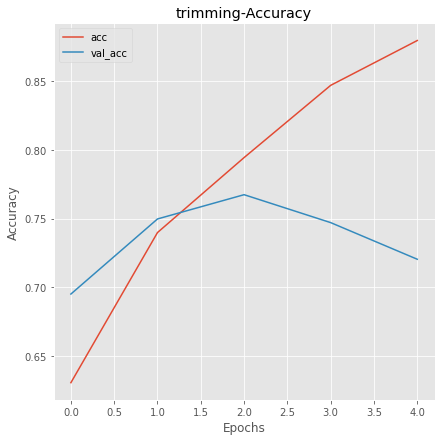

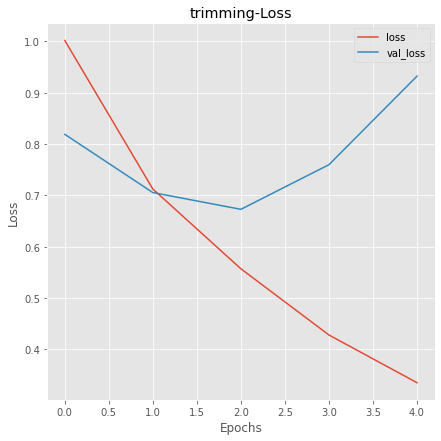

In [35]:
model_plots(history,'trimming')